# How to write number? by GAN of course!

Lets assume, you are a guy who have just heard about GAN, you have read some stuffs but cannot know what they are bluffering about. Or you have already knew the basic consepts of GAN, but still have some questions in detail. And most importantly, you are eager to build some cool stuffs but do not know where to start. If that is the case, then Congratulations! This is exactly what you need.

We are going to build a GAN that trains on MNIST dataset and is capable of generating hand-written-like number images with the specified content. To achieve this, we are replacing the traditional binary classification discriminator to multiple classification, and labels are introduced in the latent variables (input of generator).

## References and further reading
#### Generative Adversarial Networks: Build Your First Models
- by Renato Candido et.al.
- Published in Real Python, 
<https://realpython.com/generative-adversarial-networks/>

This article provides quite a lot of ideas for the article you are watching. Actually, you could regard this one as the modification and expansion of the article above. Of course, that article stops at building a GAN for MNIST without prompt or label input, and this article aims to share the successful experience of exploring and extending that work. It is suggested that if you are unfamiliar with some concepts in this article, you could watch that one ahead.

#### Generative Adversarial Networks
- Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio
- Available here <https://arxiv.org/abs/1406.2661>

The original paper of GAN, the place where the entire story begins, it is fun to have a peak isn't it.

#### Improved Techniques for Training GANs
- Tim Salimans, Ian Goodfellow, Wojciech Zaremba, Vicki Cheung, Alec Radford, Xi Chen
- Available here <https://arxiv.org/abs/1606.03498>

Written by those guys who invented GAN, an article for GAN training techniques.

#### Unsupervised Image-to-Image Translation Networks
- Ming-Yu Liu, Thomas Breuel, Jan Kautz
- Available here <https://arxiv.org/abs/1703.00848>

Advance application of GAN. If you are extremely interested in GAN and image-to-image trainslation, it is recommended.


## Environment setup
We are using pytorch to build the model, you can go to <https://pytorch.org/> to download it. We are using matplotlib (<https://matplotlib.org/>) to plot the image, it is optional since pytorch also provides convinient interface to save the images. Feel free to modify some code if you really have problem with installation (or you hate the package very much). I also recommend you to use conda for package managing, if you do not know it, go to <https://www.anaconda.com/download> to download, spend an afternoon to get familiar with it, and enjoy.

In [16]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import time

The following code is about setting up device and downloading dataset. Pick a number you like as the `seed`, and choose your device. The MNIST dataset will be downloaded to your disk, by default is at here, you can modify it by changing `mnist_path`. Since it is the generation task rather than identification task, we do not need to split train and test sets, but label is needed since contents requires supervision. And choose your `batch_size` for optimul training.

In [17]:
seed = 95
mnist_path = '.'
batch_size = 32


torch.manual_seed(seed)

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_set = torchvision.datasets.MNIST(
    root=mnist_path, train=True, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

cuda


## Network structure
![struct](struct.png)
The GAN network composed by two subnetworks as conventional GAN. Output of Generator $G$ and input of discriminator $D$ are Images with the format of MNIST data ($1\times 28\times 28$ image). Input of $G$ is a 42 dimention vector, the first 10 of it is hotkey of 0-9, providing prompt for the Generator. Output of $D$ is 11 dimentional, meaning a 11 classifier with classes defined as identifying 0-9 and unrecognizable. All the layers are linear for simplification.

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 11),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
    
discriminator = Discriminator().to(device=device)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(42, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)



## Training
First define two functions for utility.

In [19]:

def labelToHotKey(labels,classes,device):
    real_samples_labels = torch.zeros((len(labels), classes),device=device)
    for label,target in zip(labels,real_samples_labels):
        target[label] = 1

    return real_samples_labels

def genLatentSpace(labels,device):
    latent_space_samples = torch.randn((len(labels), 32),device=device)
    hotkey_labels = labelToHotKey(labels,10,device)
    return torch.cat((hotkey_labels,latent_space_samples),dim=1), labels


Since all the loss are calculated at the output of $D$, which is a classification problem, we choose Cross-Entropy Loss, there are two optimization tasks for both Discriminator and Generator, we define two Adam optimizers. Learning rate `lr` is suggested to be smaller, and `num_epochs` could be adjusted based on your device and the time you want to cost.

For each batch of data, we split the training into two parts. First is the discriminator part, we blend render generated image and real image from MNIST together, and provide true labels. For true images, labels are as it is, for render generated images, labels are set to 'unrecognized' for telling discriminator that those are generated. We are using `optimizer_discriminator` optimizer to handle the update. The `backward()` operation will calculate the derivative of the entire network, however, since we have input only the discriminator's parameters, the optimizer will only update the discriminator. Second, we train the generator. Since we hope that generator could output digits as prompt commanded, we will provide labels based on input prompt. Loss are calculated at the output of discriminator, but our optimizer `optimizer_generator` takes input of only generator's parameters, the update will not change discriminator.

If you fell that for Generator and Discriminator, one is significantly stronger than the other, you could adjust training bias, that is you could either provide more training iterations for the weak, or assign different learning rate for them to balance the performance.

In [20]:

lr = 0.0001
num_epochs = 20

loss_function = nn.CrossEntropyLoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

start_time = time.time()

for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        batch_size = len(mnist_labels)
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        mnist_labels = mnist_labels.to(device)
        real_samples_labels = labelToHotKey(mnist_labels,11,device)

        latent_space_samples,_ = genLatentSpace(torch.randint(0,10,size=(batch_size,),device=device),device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 11)).to(
            device=device
        )
        generated_samples_labels[:,10] = 1
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples, gen_labels = genLatentSpace(torch.randint(0,10,size=(batch_size,),device=device),device)
        real_samples_labels = labelToHotKey(gen_labels,11,device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

    print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
    print(f"Epoch: {epoch} Loss G.: {loss_generator}")

endtime = time.time() - start_time
print('trained time: ',endtime)

Epoch: 0 Loss D.: 1.7110393047332764
Epoch: 0 Loss G.: 1.676532506942749
Epoch: 1 Loss D.: 1.6947855949401855
Epoch: 1 Loss G.: 1.6852365732192993
Epoch: 2 Loss D.: 1.6806467771530151
Epoch: 2 Loss G.: 2.016265869140625
Epoch: 3 Loss D.: 1.616213083267212
Epoch: 3 Loss G.: 2.4191174507141113
Epoch: 4 Loss D.: 1.6142828464508057
Epoch: 4 Loss G.: 2.457461357116699
Epoch: 5 Loss D.: 1.5574415922164917
Epoch: 5 Loss G.: 2.508073091506958
Epoch: 6 Loss D.: 1.5647692680358887
Epoch: 6 Loss G.: 2.4915645122528076
Epoch: 7 Loss D.: 1.61936354637146
Epoch: 7 Loss G.: 2.336106538772583
Epoch: 8 Loss D.: 1.6083598136901855
Epoch: 8 Loss G.: 2.4015231132507324
Epoch: 9 Loss D.: 1.6221799850463867
Epoch: 9 Loss G.: 2.220031261444092
trained time:  434.67056941986084


## Output
Finally, lets see the output. We could directly plot the image using matplotlib. For giving a straight forward observation that we could control the digit if output, lets generate 10 outputs from 0 to 9.

Here we could apply another trick, that is to set a threshold as `thres`. If the value of a pixel is above threshold, then it is set as 1 otherwise 0. It will delete gray values and reduce noise for the output images.

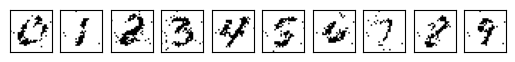

In [26]:
labels = torch.tensor(range(10))
latent_space_samples,_ = genLatentSpace(labels,device)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()

thres = 0.6
dothres = True

if(dothres):
    generated_samples = generated_samples > thres

for i in range(len(labels)):
    ax = plt.subplot(1,len(labels), i + 1)
    plt.imshow((generated_samples[i]).reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

The output image should be something like

![](output.png)

If not, please be patient, find out the problem and solve it.

Good Luck!